In [12]:
import sys
import os

# Add the path to the volatility_analysis directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, 'code', 'volatility_analysis'))

# Import the volatility analysis library directly
from volatility_pipeline import *

import torch
torch.set_grad_enabled(True)
print(f"Gradients enabled: {torch.is_grad_enabled()}")

Gradients enabled: True


In [13]:
FETCH_DATA = False # Set to True to fetch new news data
FROM, TO = "2023-01-01", "2025-12-31"
CUT = "2024-10-01"  # Date to split train/test data
TOPIC = "BUSINESS"
MARKET_NAME = "DAX 40"
WINDOW = 7
EPOCHS = 200
LSTM_TYPE = "simple"  # Options: "improved", "simple"
USE_TECHNICAL_INDICATORS = False

In [14]:
keywords = [
    "dax",  # German stock index (equivalent to IBEX 35)
    "inflation",  # Inflation
    "zinssatz",  # Interest rates
    "zölle",  # Tariffs
    "wirtschaftswachstum",  # Economic growth
    "rezession",  # Recession
    "arbeitslosigkeit",  # Unemployment
    "subventionen",  # Subsidies
    "investition",  # Investment
    "expansion"  # Expansion
]

KEYWORDS = " OR ".join([f'"{keyword}"' for keyword in keywords])

In [15]:
import pandas as pd, time, random
from pygooglenews import GoogleNews
# Fetch news data function
def fetch_dax_news_data():
    gn = GoogleNews(lang="de", country="DE")

    all_frames = []

    start_dt = pd.to_datetime(FROM)
    end_dt   = pd.to_datetime(TO)

    while start_dt <= end_dt:
        stop_dt = min(start_dt + pd.Timedelta(days=WINDOW-1), end_dt)

        feed    = gn.search(KEYWORDS,
                            from_=start_dt.strftime("%Y-%m-%d"),
                            to_  =stop_dt.strftime("%Y-%m-%d"))

        df      = pd.DataFrame(
                    {"date":  [pd.to_datetime(e.published).tz_localize(None)
                                for e in feed["entries"]],
                    "title": [e.title for e in feed["entries"]]}
                )
        all_frames.append(df)

        # polite pause to avoid 429 errors
        time.sleep(random.uniform(1.0, 2.5))
        start_dt = stop_dt + pd.Timedelta(days=1)

    news_df = (pd.concat(all_frames, ignore_index=True)
                .drop_duplicates())          # remove overlaps
    
    # Remove the "- name of the news source" suffix from titles
    news_df['title'] = news_df['title'].str.replace(r' - .+$', '', regex=True)
    

    # Save to CSV
    os.makedirs("../news", exist_ok=True)
    news_df.to_csv(f"../news/news_data_{FROM}_{TO}_DAX.csv", index=False)
    
    return news_df

In [16]:
# Fetch or load news data
if FETCH_DATA:
    news_df = fetch_dax_news_data()
    print(f"Fetched {len(news_df)} news articles")
else:
    # Read the CSV file
    news_df = pd.read_csv(f"../news/news_data_{FROM}_{TO}_DAX.csv", parse_dates=['date'])
    print(f"Loaded {len(news_df)} news articles")

Loaded 11711 news articles


In [17]:
import yfinance

# Fetch DAX 40 market data using yfinance
dax40 = yfinance.Ticker("^GDAXI")
dax40_data = dax40.history(start=FROM, end=TO, interval="1d", auto_adjust=True)
dax40_data = dax40_data.reset_index()  # Convert index to column
dax40_data["Returns"] = dax40_data["Close"].pct_change()
dax40_data["Volatility"] = dax40_data["Returns"].rolling(window=21).std() * np.sqrt(252)
dax40_data = dax40_data.dropna().reset_index(drop=True)

print(f"Loaded {len(dax40_data)} days of DAX 40 market data")
dax40_data.head()

Loaded 589 days of DAX 40 market data


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Volatility
0,2023-01-31 00:00:00+01:00,15081.169922,15136.219727,14993.589844,15128.269531,57047200,0.0,0.0,0.000145,0.123464
1,2023-02-01 00:00:00+01:00,15125.120117,15222.339844,15107.830078,15180.740234,57095200,0.0,0.0,0.003468,0.122377
2,2023-02-02 00:00:00+01:00,15275.000000,15520.969727,15264.309570,15509.190430,122979300,0.0,0.0,0.021636,0.122071
3,2023-02-03 00:00:00+01:00,15408.400391,15476.669922,15347.860352,15476.429688,76253700,0.0,0.0,-0.002112,0.121006
4,2023-02-06 00:00:00+01:00,15367.040039,15406.929688,15275.570312,15345.910156,54430400,0.0,0.0,-0.008433,0.123242


Splitting data at 2024-10-01...
Sentiment model loaded on device: cuda
GPU: NVIDIA GeForce RTX 4070
Calculating enhanced sentiment scores...
Plotting sentiment distribution...


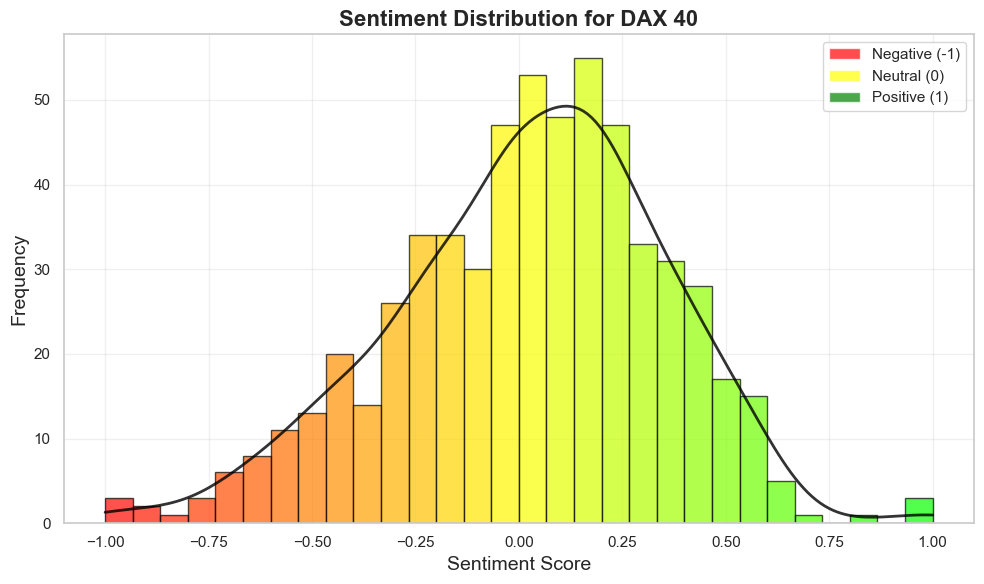

Final feature columns for model: ['Volatility_Smooth', 'news_sentiment_interaction', 'sentiment_mean_3d', 'sentiment_mean_5d', 'sentiment_mean_7d', 'sentiment_std_7d']


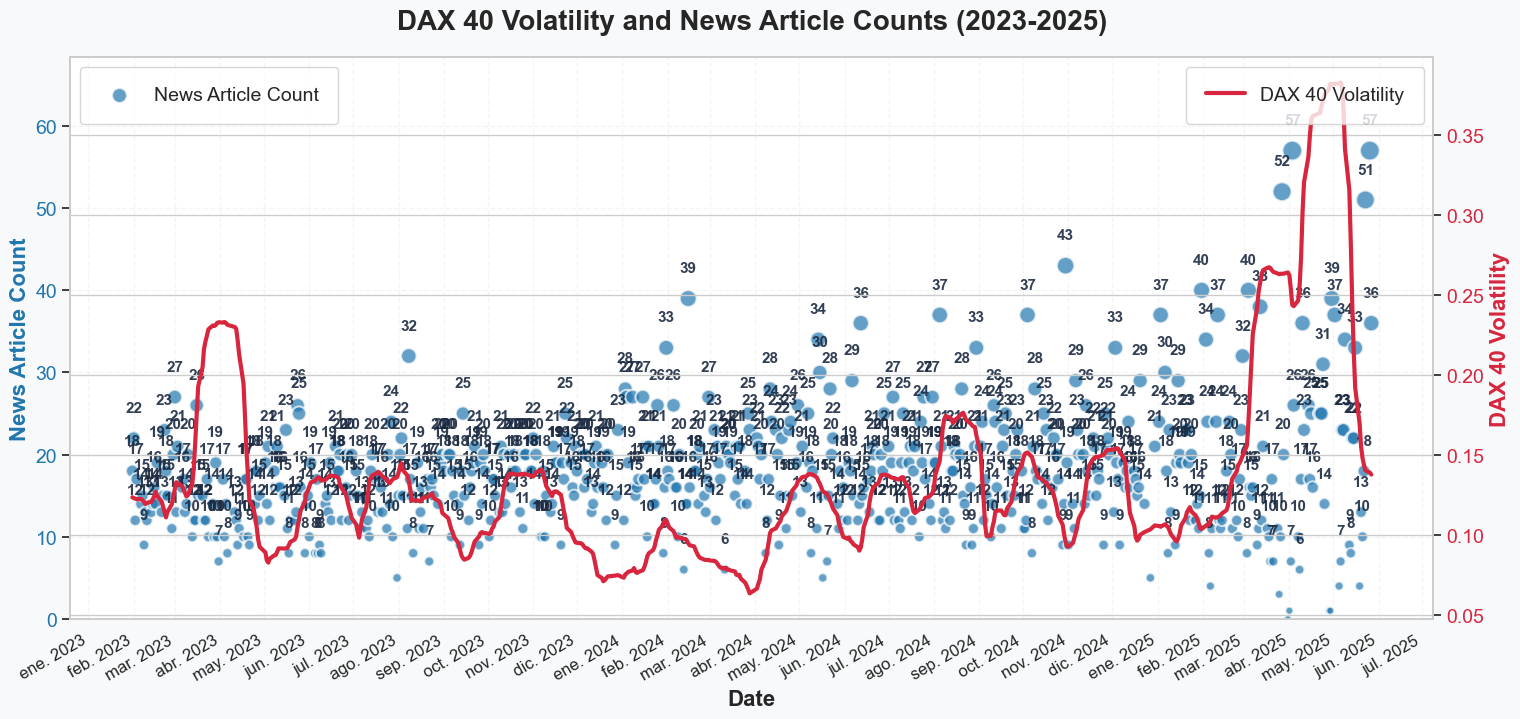

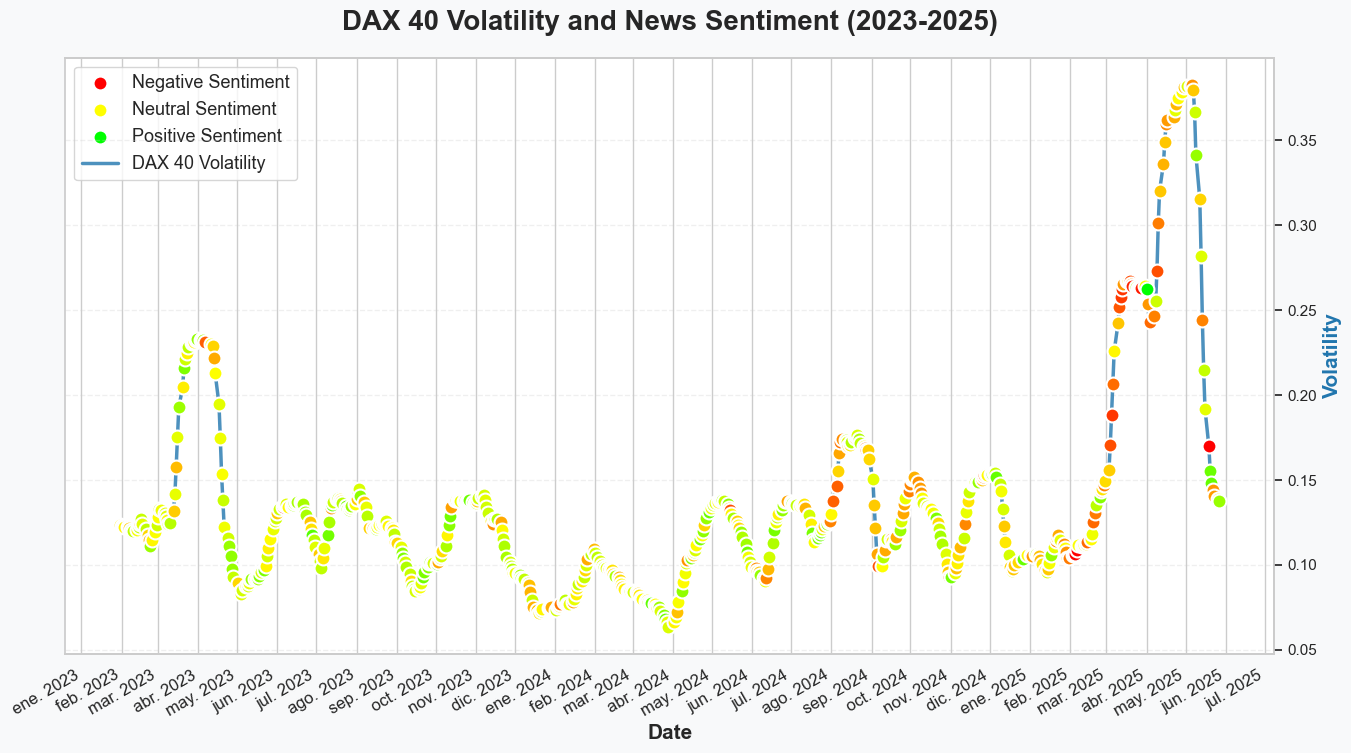

Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Model initialized with 5314 trainable parameters
Epoch 1/200, Train Loss: 0.16609, Val Loss: 0.11224
Epoch 10/200, Train Loss: 0.01370, Val Loss: 0.01562
Epoch 20/200, Train Loss: 0.00702, Val Loss: 0.01158
Epoch 30/200, Train Loss: 0.00520, Val Loss: 0.00985
Epoch 40/200, Train Loss: 0.00356, Val Loss: 0.00848
Epoch 50/200, Train Loss: 0.00238, Val Loss: 0.00700
Epoch 60/200, Train Loss: 0.00179, Val Loss: 0.00571
Epoch 70/200, Train Loss: 0.00155, Val Loss: 0.00493
Epoch 80/200, Train Loss: 0.00141, Val Loss: 0.00445
Epoch 90/200, Train Loss: 0.00131, Val Loss: 0.00408
Epoch 100/200, Train Loss: 0.00122, Val Loss: 0.00378
Epoch 110/200, Train Loss: 0.00114, Val Loss: 0.00351
Epoch 120/200, Train Loss: 0.00106, Val Loss: 0.00328
Epoch 130/200, Train Loss: 0.00100, Val Loss: 0.00308
Epoch 140/200, Train Loss: 0.00094, Val Loss: 0.00289
Epoch 150/200, Train Loss: 0.00088, Val Loss: 0.00273
Epoch 160/200

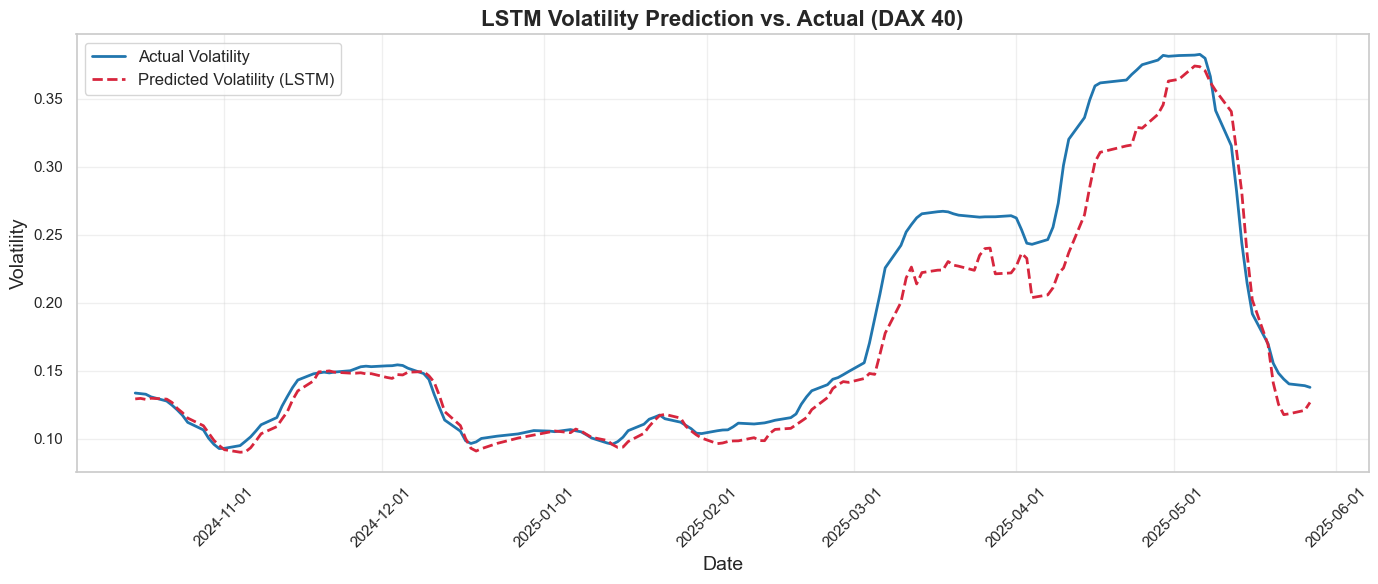

In [18]:
# Run the volatility analysis pipeline
results = run_volatility_pipeline(
    news_df=news_df,
    stock_data=dax40_data,
    market_name=MARKET_NAME,
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=EPOCHS,
    learning_rate=0.001,
    verbose=True,
    use_technical_indicators=USE_TECHNICAL_INDICATORS,
    lstm_type=LSTM_TYPE,
    patience=100
)

Splitting data at 2024-10-01...
Skipping sentiment calculation (use_sentiment=False)...
Final feature columns for model: ['Volatility_Smooth']
Preparing data for LSTM model...
Training enhanced LSTM model with early stopping...
Model initialized with 4674 trainable parameters
Epoch 1/200, Train Loss: 0.12718, Val Loss: 0.09221
Epoch 10/200, Train Loss: 0.00773, Val Loss: 0.00602
Epoch 20/200, Train Loss: 0.00505, Val Loss: 0.00441
Epoch 30/200, Train Loss: 0.00272, Val Loss: 0.00271
Epoch 40/200, Train Loss: 0.00199, Val Loss: 0.00218
Epoch 50/200, Train Loss: 0.00178, Val Loss: 0.00200
Epoch 60/200, Train Loss: 0.00159, Val Loss: 0.00190
Epoch 70/200, Train Loss: 0.00163, Val Loss: 0.00183
Epoch 80/200, Train Loss: 0.00142, Val Loss: 0.00166
Epoch 90/200, Train Loss: 0.00137, Val Loss: 0.00160
Epoch 100/200, Train Loss: 0.00132, Val Loss: 0.00154
Epoch 110/200, Train Loss: 0.00127, Val Loss: 0.00149
Epoch 120/200, Train Loss: 0.00122, Val Loss: 0.00144
Epoch 130/200, Train Loss: 0.001

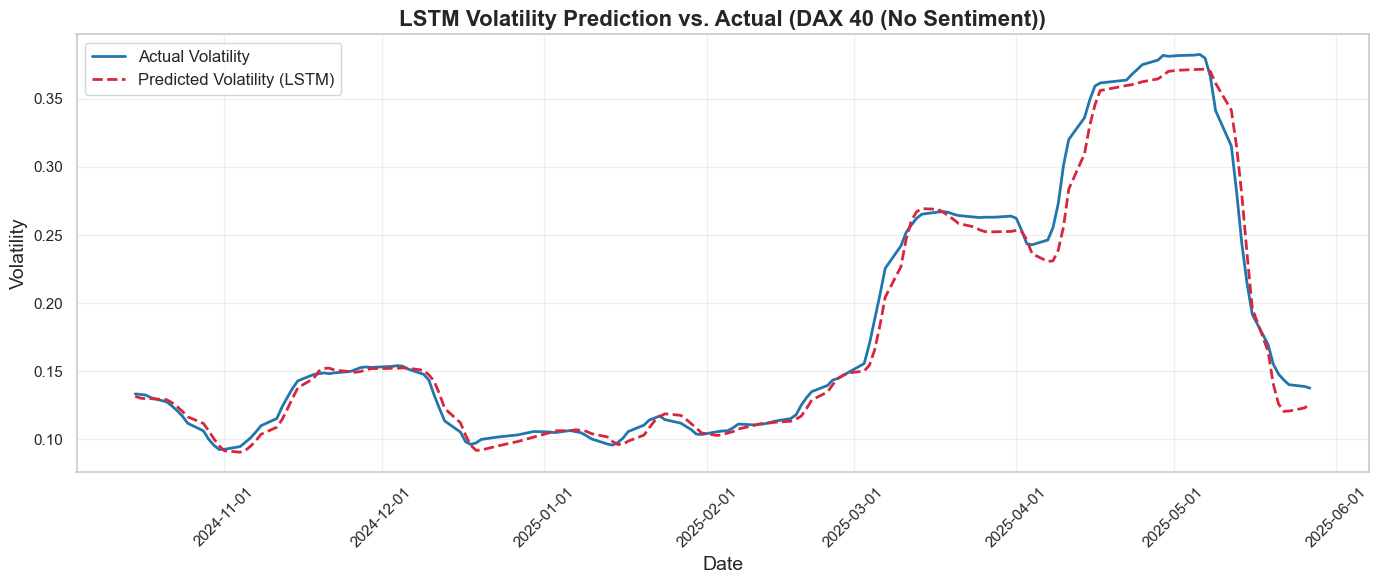

In [19]:
results_no_sentiment = run_volatility_pipeline(
    news_df=news_df,
    stock_data=dax40_data,
    market_name=MARKET_NAME + " (No Sentiment)",
    cut_date=CUT,
    output_dir="../news",
    seq_len=10,
    epochs=EPOCHS,
    learning_rate=0.001,
    use_sentiment=False,
    verbose=True,
    use_technical_indicators=USE_TECHNICAL_INDICATORS,
    lstm_type=LSTM_TYPE,
)

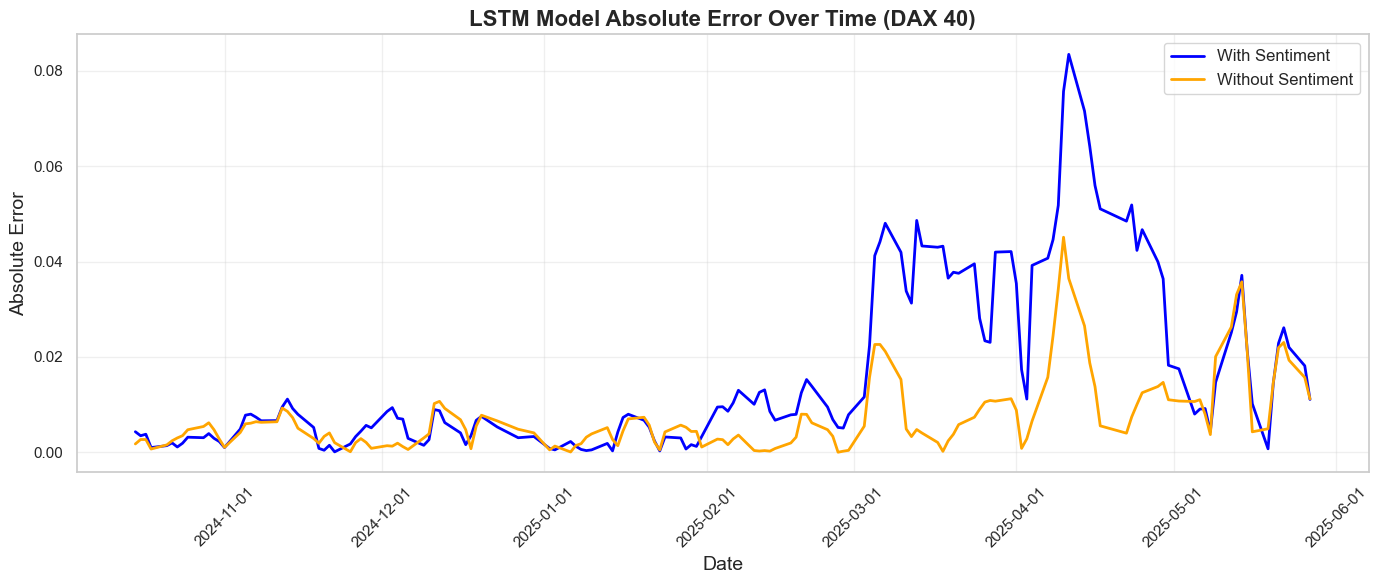

In [20]:
import matplotlib.pyplot as plt
# Plot the MAE over time for both models
plt.figure(figsize=(14, 6))
plt.plot(results['test_dates'], np.abs(results['y_actual'] - results['y_pred']), label='With Sentiment', color='blue', linewidth=2)
plt.plot(results_no_sentiment['test_dates'], np.abs(results_no_sentiment['y_actual'] - results_no_sentiment['y_pred']), label='Without Sentiment', color='orange', linewidth=2)
plt.title('LSTM Model Absolute Error Over Time (DAX 40)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Compare metrics between sentiment-based and volatility-only models
print("\n=== MODEL COMPARISON ===")
print("With Sentiment:")
for metric_name, value in results['metrics'].items():
    print(f"  {metric_name}: {value:.6f}")

print("\nWithout Sentiment:")
for metric_name, value in results_no_sentiment['metrics'].items():
    print(f"  {metric_name}: {value:.6f}")


=== MODEL COMPARISON ===
With Sentiment:
  MSE: 0.000585
  RMSE: 0.024181
  MAE: 0.016219
  R2: 0.925658

Without Sentiment:
  MSE: 0.000122
  RMSE: 0.011027
  MAE: 0.007478
  R2: 0.984542
